In [1]:
from gensim import downloader
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
def get_details(dataframe,wv_model):

    details_list = []
    #going through dataset and evaluating the closest synonym to the question
    for index, row in dataframe.iterrows():
        question=row['question']
        answer=row['answer']
        system_guess_word=''
        best_choice_similarity=-1
        
        if question in wv_model.key_to_index:        
            for index in range(0,4):
                choice=row[str(index)]
                if choice in wv_model.key_to_index:
                    choice_similarity=wv_model.similarity(question,choice)
                    if choice_similarity>best_choice_similarity:
                        best_choice_similarity=choice_similarity
                        system_guess_word=choice
        
        #validate label
        if best_choice_similarity==-1:
            label='guess'
            #If label is "guess" then choose the system word randomly
            random_column = str(random.randint(0,3))
            system_guess_word= row[random_column]
        elif answer==system_guess_word:
            label='correct'
        else:
            label='wrong'
        #add each row to the list
        details_list.append([question,answer,system_guess_word,label])
        #print(f"{question},{answer},{system_guess_word},{label}")
    
    return details_list

In [3]:
#generate output file with details
def generate_details_file(model_name,details_list):
    output_file_name=f"{model_name}-details.csv"
    with open(output_file_name, 'w') as output_file:
        for row in details_list:            
            for index in range(0,4):
                if(index==0):                    
                    output_file.write(row[index])  
                else:
                    output_file.write(',' + row[index])
            output_file.write('\n')

In [4]:
#append results from each model to analysis file
def append_results(model_name,vocabulary_size,details_list):
    
    output_file_name = "analysis.csv"
    #C is count_correct
    C = 0
    count_guess = 0
    
    for row in details_list:
        if row[3] == 'correct':            
            C +=1
        elif row[3] == 'guess':
            count_guess +=1
    #V  is number of questions without guess
    V = len(details_list) - count_guess
    model_accuracy = C / V

    with open(output_file_name, 'a') as output_file:
         output_file.write(f"{model_name},{vocabulary_size},{C},{V},{model_accuracy}\n")

In [5]:
# Load dataset
dataframe = pd.read_csv('synonym.csv')

In [6]:
#Task 1
#Load wv_google
wv_google=downloader.load('word2vec-google-news-300')
list_details = get_details(dataframe,wv_google)
generate_details_file('word2vec-google-news-300',list_details)
vocabulary_size = len(wv_google.key_to_index)
append_results('word2vec-google-news-300',vocabulary_size,list_details)

In [7]:
#Task 2
# 2 new models from different corpora, but with the same embedding size 100

c1_e1 = 'English-CoNLL17-100'
model = KeyedVectors.load_word2vec_format('./40/model.bin', binary=True)
list_details = get_details(dataframe,model)
generate_details_file(c1_e1,list_details)
vocabulary_size = len(model.key_to_index)
append_results(c1_e1,vocabulary_size,list_details)

c2_e2 = 'glove-wiki-gigaword-100'
model = downloader.load(c2_e2)
list_details = get_details(dataframe,model)
generate_details_file(c2_e2,list_details)
vocabulary_size = len(model.key_to_index)
append_results(c2_e2,vocabulary_size,list_details)

In [8]:
# 2 models from the same corpus but different embedding sizes
c3_e3 ='glove-twitter-100'
model = downloader.load(c3_e3)
list_details = get_details(dataframe,model)
generate_details_file(c3_e3,list_details)
vocabulary_size = len(model.key_to_index)
append_results(c3_e3,vocabulary_size,list_details)

c4_e4 ='glove-twitter-200'
model = downloader.load(c4_e4)
list_details = get_details(dataframe,model)
generate_details_file(c4_e4,list_details)
vocabulary_size = len(model.key_to_index)
append_results(c4_e4,vocabulary_size,list_details)

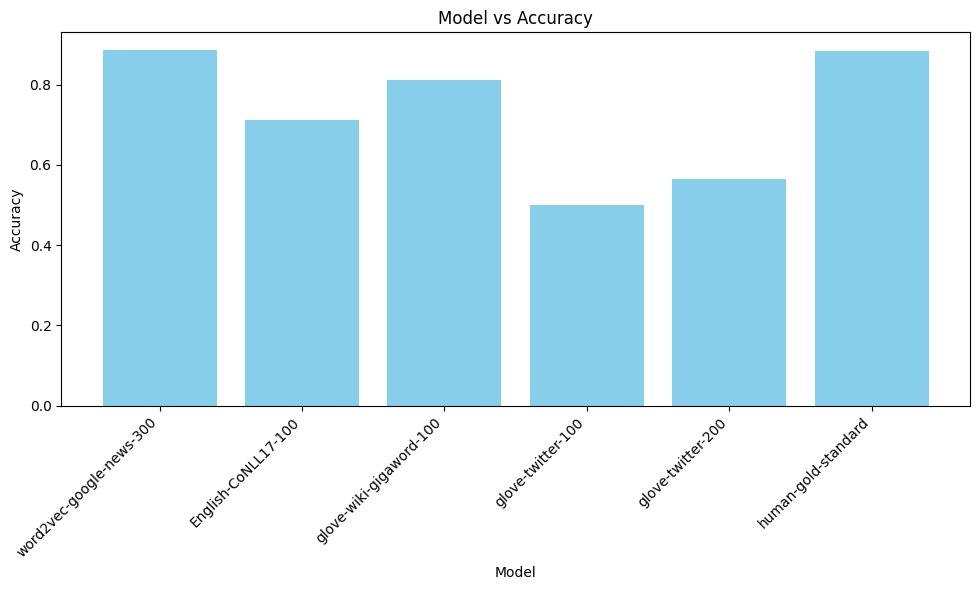

In [11]:
# Plot the model vs accuracy

# Load analysis results
dataframe = pd.read_csv('analysis.csv', header=None)
#Add collective Human Gold-Standard
gold_standard = ['human-gold-standard',0,0,0,0.885]
dataframe.loc[len(dataframe)] = gold_standard

#plot
plt.figure(figsize=(10, 6))
plt.bar(dataframe[0], dataframe[4], color='skyblue')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.title('Model vs Accuracy')
plt.tight_layout()
plt.show()